### 1.1 Read in the contents of both csv files.

In [ ]:
import pandas as pd


training_stats = pd.read_csv("training.csv")
testing_stats = pd.read_csv("testing.csv")

### 1.2 Inspect the columns and first few lines of both files.

In [160]:
training_stats.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,67,51,68,115,69,111,136,31,67,...,-9.17,-18.27,-1.80,-6.32,-20.88,-1.63,-6.13,-22.56,-5.53,-8.11
1,s,67,28,51,99,50,97,82,26,59,...,-2.25,-20.13,-2.11,-6.35,-21.94,-1.22,-6.13,-22.20,-3.41,-6.57
2,s,63,26,50,95,49,91,81,26,57,...,-0.44,-17.64,-1.81,-4.70,-19.39,-0.65,-5.01,-20.89,-3.96,-6.85
3,d,63,42,63,97,66,108,111,28,59,...,-2.34,-20.20,-1.89,-5.47,-21.65,-0.99,-5.71,-22.19,-3.41,-6.52
4,s,46,27,50,83,51,90,76,26,56,...,1.25,-18.62,-2.17,-7.11,-21.12,-1.56,-6.35,-22.19,-4.45,-7.32


In [ ]:
testing_stats.head()

### 1.3 Visualizing data 

#### We will visualize the data in `training.csv` file.
First, we will look at the general distribution of all the variables in the dataframe. We do this by divide the original dataframe into three dataframes: 
 - `training_pred_H` contains columns whose names have `pred_minus_obs_H`,
 - `training_pred_S` contains columns whose names have `pred_minus_obs_S`,
 - `training_data` contains columns whose names do not have `pred_minus_obs`.

And then we will look at their relationships by grouping each of them up by `class`

In [169]:
import matplotlib.pyplot as plt
import numpy as np


training_pred_H = training_stats.filter(regex='pred_minus_obs_H|class')
training_pred_S = training_stats.filter(regex='pred_minus_obs_S|class')
training_data = training_stats.filter(regex='^(?!pred_minus_obs)')

The following graphs are visualized by variables with `pred_minus_obs_H`.
We can see that there is a clear distribution for each variables.

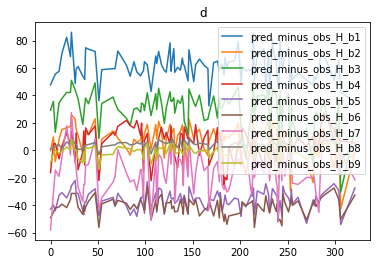

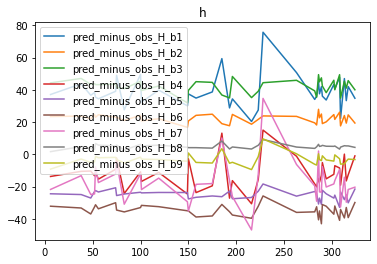

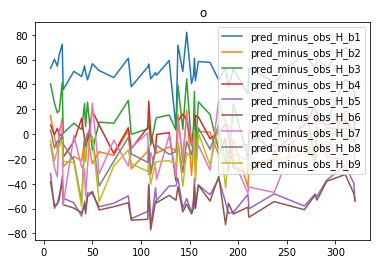

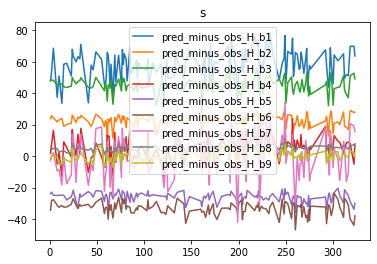

In [170]:
for key, gp in training_pred_H.groupby("class"):
    gp.plot()
    plt.title(key)
    plt.show()

The following graphs are visualized by variables with `pred_minus_obs_S`. The distributions of some variables are mixed up with others.

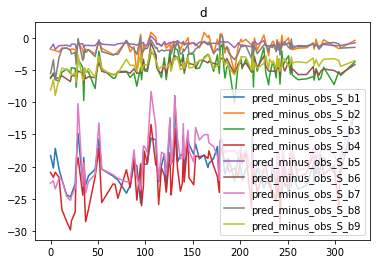

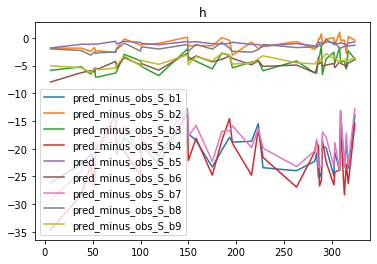

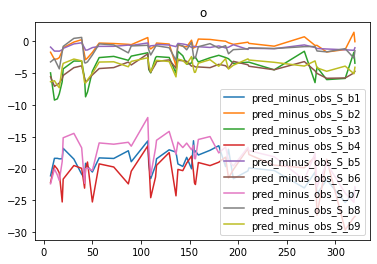

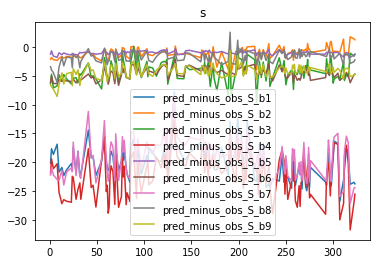

In [171]:
for key, gp in training_pred_S.groupby("class"):
    gp.plot()
    plt.title(key)
    plt.show()

The following graphs are visualized by variables without `pred_minus_obs`. These variables have similiar shapes of lines with each other but with different levels of value.

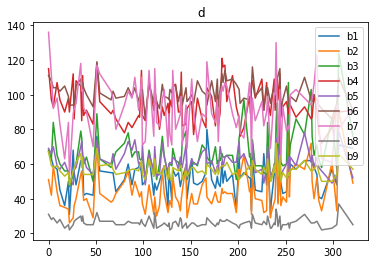

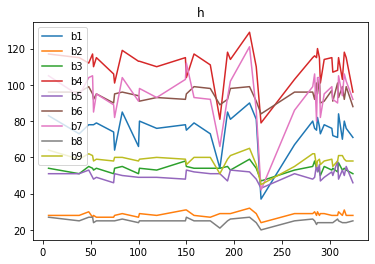

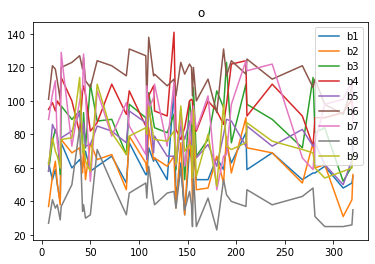

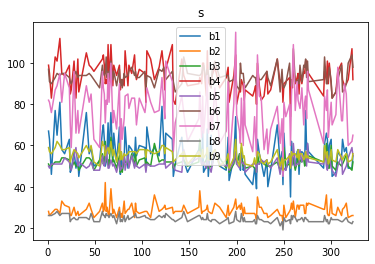

In [172]:
for key, gp in training_data.groupby("class"):
    gp.plot()
    plt.title(key)
    plt.show()

We will then visualize variables which have "b1" in their names to see their relationships. We will divide them up by grouping the data by `class`

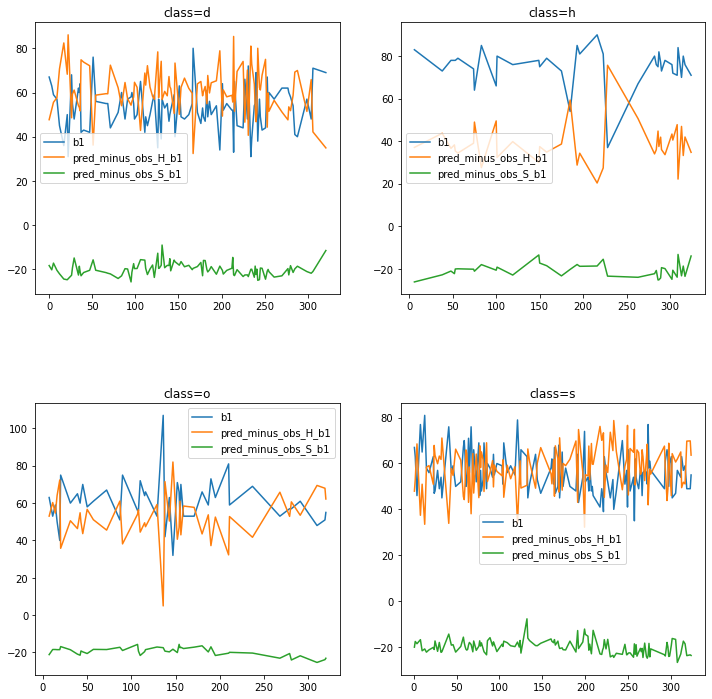

In [166]:
training_data_b1 = training_stats.filter(regex='b1|class')

fig, axs = plt.subplots(figsize=(12,12), 
                        nrows=2, ncols=2, 
                        gridspec_kw=dict(hspace=0.4))



targets = zip(training_data_b1.groupby("class"), axs.flatten())


for (key, gp), ax in targets:
    gp.plot(ax=ax)
    ax.set_title('class=%c'%key)

plt.show()

We can see that `pred_minus_obs_H_b1` and `b1` distributed symmetrically on both sides of the value 60 in the y axis (roughly). While `pred_minus_obs_S_b1` distributed around -20.

### 2 Remove all the columns whose names begin with `pred_minus_obs`

In [175]:
training_stats = training_stats[training_stats.columns.drop(list(training_stats.filter(regex='pred_minus_obs')))]
training_stats.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,d,67,51,68,115,69,111,136,31,67
1,s,67,28,51,99,50,97,82,26,59
2,s,63,26,50,95,49,91,81,26,57
3,d,63,42,63,97,66,108,111,28,59
4,s,46,27,50,83,51,90,76,26,56


In [176]:
testing_stats = testing_stats[testing_stats.columns.drop(list(testing_stats.filter(regex='pred_minus_obs')))]
testing_stats.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,d,39,36,57,91,59,101,93,27,60
1,h,84,30,57,112,51,98,92,26,62
2,s,53,25,49,99,51,93,84,26,58
3,s,59,26,49,103,47,92,82,25,56
4,d,57,49,66,103,64,106,114,28,59


### 3 Count the number of instances for each class label.

for training data:

In [177]:
training_stats['class'].value_counts()

s    136
d    105
o     46
h     38
Name: class, dtype: int64

We can see that the `class` with value `o` and `h` have less counts than `s` and `d`. So the training set may be imbalanced.

for testing data:

In [178]:
testing_stats['class'].value_counts()

s    59
d    54
h    48
o    37
Name: class, dtype: int64

### 4 Classification

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.028) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.974 (+/-0.012) for {'C': 1, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 10, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 100, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed o

In [3]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [5]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [6]:
y

array([0, 1, 2, ..., 8, 9, 8])